In [109]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

# This code solves the moist energy balance model (MEBM) used in Roe et al. (Nat. Geosci., 2015)
# It also includes the Hadley Cell parameterization used in Siler et al. (Journal of Climate 2018) to route tropical moisture in the correct direction
# It predicts moisture convergence, and thus evaporation minus precipitatation (E-P), from which P is calculated with a simple representation of E
# The model operates in climatology mode
# You can specify:-
# the insolation (Q0)
# the OLR parameters (A0,B0)
# the diffusivity (D)
# albedo of ocean and ice
# whether you diffuse moist static energy, or just sensible heat


In [110]:
#time step in fraction of year
delt=1./50000;
NMAX=1000000; #maximum number of timesteps

#set up grid for model (x = sine of latitude).
jmx=101; #number of grid points
delx = 2.0/jmx;
x = np.arange(-1.0+delx/2,1.0,delx) #grid points
phi = np.arcsin(x)*180/np.pi; #latitude at each grid point

# C = rho * c * h_ml /(pi*1e7).
Cl = 0.2; # heat capacity, units: J /(m2 K) consistent with 1 meter of dirt (low heat capacitity for fast convergence)

In [111]:
# climate parameters
Q0 = 342;                          # [W m-2]  solar constant
A0 = 207.3;                        # Size of longwave cooling constant [W/m2]
B0 = 2.09;                         # [W m-2 degC-1] OLR response NOTE UNITS
alf_noice = 0.3;                   # [] ice free albedo.
alf_ice = 0.55;                    # [] ice covered albedo.

# part d: modify ice albedo to ice free albedo
alf_ice = 0.3;

A = A0;
B = B0*np.ones(x.size); # longwave cooling [W/(m2 K)]

In [112]:
# Moisture parameters
relhum = 0.8;   # relative humidity
eps = 0.622;    # moisture coonstant
psfc = 9.8e4;   # (Pa)
e0 = 611.2;     # vap. press (Pa)
a = 17.67; b = 243.5;   # sat vap constants !!T must be in Celcius
L = 2.45e6;         # latent heat of vaporization (J kg-1)
cp = 1004;          # (J kg-1 K-1)

In [113]:
# magnitude of diffusivity
Dmag = 0.2598; # D = 0.2598 W/(m2 K) is the value used by TF10 
D=Dmag*np.ones(jmx+1); # diffusivity for MSE

In [114]:
# For dry energy balance model, uncomment these lines:
# Dmag = 0.44; # magnitude of diffusivity [W/(m2 K)]
# D=Dmag*np.ones(jmx+1); # diffusivity for sensible (cp*T)
# relhum = 0;  # switch off humidity

In [115]:
#Create matrix to take a divergence of something it acts on   
#set up lambda array. Note: lambda is not feedback here.
lam=(1-np.square(np.arange(-1.0,1.0+delx,delx)))/np.square(delx);
lam=np.multiply(D, lam); 

M = np.zeros((jmx,jmx));

M[0,0] =  - lam[1];
M[0,1] = lam[1];

M[jmx-1,jmx-2] = lam[jmx-1];
M[jmx-1,jmx-1]   = - lam[jmx-1];

for j in range(1, jmx-1): 
  M[j,j-1] = lam[j]
  
  M[j,j]   = - (lam[j+1]+lam[j])
  
  M[j,j+1] = lam[j+1]


Mdiv = M; #Divergence matrix    

In [116]:
#set up inital T profile 
T = 0.5*(1-1*x*x)
Tinit=T;
Tglob = np.mean(Tinit)
#T.shape

In [117]:
# Timestepping loop. Note that it takes a few mins to run this part
for j in range(0, NMAX-1): # use NMAX-1 #for n=1:NMAX
   
   #print(np.mean(T)) 
  
   # Calculate Source  (ASR) for this loop:
    # currently sets albedo to that of ice if local annaul T < -10C (a good approximation of what nature looks like), giving an ice albedo feedback
   alf = alf_noice*np.ones(x.size)
   for idx, item in enumerate(T):
    if item <= -10:
        alf[idx] = alf_ice 
    
   Src = Q0*(1-0.241*(3*np.square(x)-1))*(1-alf); #using 2nd Legendre polynomial for insolation
   
    # spec. hum, and theta_e
   q = eps*relhum/psfc*e0*np.exp(a*(T)/(b+(T)));  #q=q(:); # here T is in oC. q is g kg-1
   
   theta_e = 1/cp*(cp*((T)+273.15) + L*q); # note units of Kelvin are needed!!!
   
    
    # Calculate new T from Source and Sink terms.
    # Diffuse moist static energy (theta_e)
   dT = delt/Cl*(Src -A - (B*T) + np.matmul(Mdiv,theta_e));
   
   T = T + dT; 
    
   #print(np.mean(T))

  # Check to see if global mean energy budget has converged:   
   Fglob=np.mean(Src - A - (B*T))
    
   if np.absolute(Fglob) < 0.001: #if (abs(Fglob) < 0.001), break; end
        break  
print(Fglob) # global average TOA energy imbalance (should be close to zero)

0.0009999061974080002


In [118]:
print(np.mean(T)) #global average temperature -- note that with grid x=sin(lat) taking the mean is already area weighted! Yay!

15.36107940242649


In [119]:
divF = -np.matmul(Mdiv,theta_e);
h = theta_e*cp;

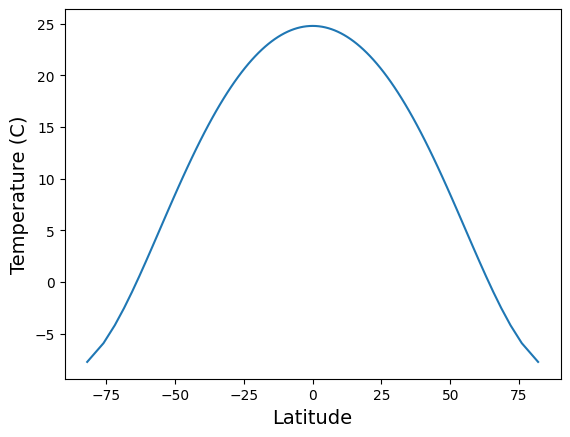

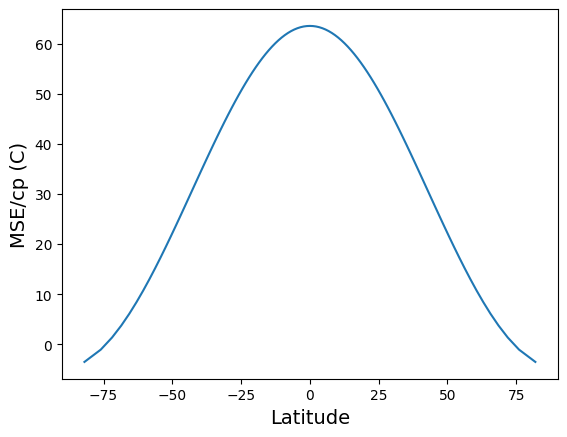

In [120]:
# Plot temperature and MSE/cp, both in units of Celcius
plt.plot(phi,T)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Temperature (C)', fontsize=14)
plt.show()

plt.plot(phi,h/cp-273.15)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('MSE/cp (C)', fontsize=14)
plt.show()


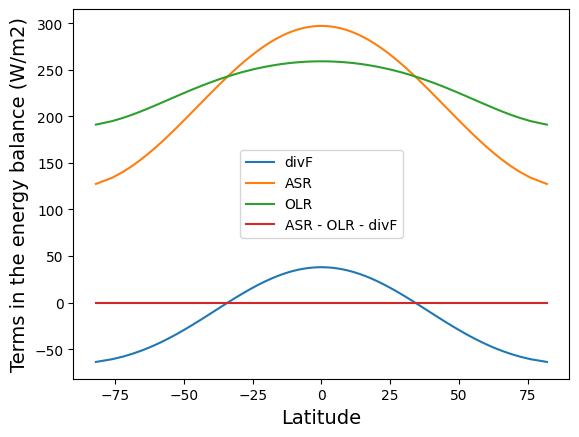

In [121]:
Snk = A+B*T
plt.plot(phi,divF) #Atmospheric heat transport convergence [W m^-2]
plt.plot(phi,Src) #Absorbed solar radiation [W m^-2]
plt.plot(phi,Snk) #Outgoing longwave radiation [W m^-2]
plt.plot(phi,Src-divF-Snk) #should be zero, but check
plt.legend(["divF", "ASR", "OLR", "ASR - OLR - divF"])
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Terms in the energy balance (W/m2)', fontsize=14)
plt.show()

In [122]:
# Module to calculate terms in hyrological cycle
T_ctrl = T
q_ctrl = eps*relhum/psfc*e0*np.exp(a*(T)/(b+(T)));  #q=q(:); # here T is in oC. q is g kg-1

# define some things from the climatology first 
Re = 6.4e6;                 # [m] earth's radius
rho = 1e3;                  # [kg m-3] density

import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.stats import norm
wt = 1-norm.pdf(x, 0, np.sin(15*2*np.pi/360))/norm.pdf(0, 0, np.sin(15*2*np.pi/360)) # define Gaussian Hadley Cell width wt = 1-gaussmf(x,[sind(15) 0]);

# calculate some things about the climatology (ctrl)
Dhlf = Dmag*np.ones(jmx)                                   # [W m-2 K-1] calculate D on same grid as T,q, etc ##0.5*(D(1:end-1)+D(2:end));  #WARNING: would need to modify this if allowing D to vary with latitude
h_ctrl = cp*(T_ctrl+273.15)+L*q_ctrl                       # [J kg-1] control climate mse
F_ctrl = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h_ctrl,x)  # [W] control climate flux 
F_lh_ctrl = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q_ctrl,x)    # [W] control latent heat flux
F_hc_ctrl = (1-wt)*F_ctrl                                 # [W] Hadley Cell Flux
heq_ctrl = h_ctrl[50]                                 #value at equator WARNING will have to change if change grid ; # [J kg-1] moist static energy at the surface
V_ctrl = F_hc_ctrl/(heq_ctrl*1.07-h_ctrl)               # [kg s-1] Diagnosed mass transport in Hadley Cell (Nick's way)

F_LH_ctrl = -L*V_ctrl*q_ctrl + wt*F_lh_ctrl              # [W] latent heat (Hadley plus eddy)
F_LH_eddy_ctrl = wt*F_lh_ctrl                         # eddy latent heat fluxes including weighting function.
divF_LH_ctrl = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH_ctrl,x)         # [W m-2] divergence of latent heat flux
E_m_P_ctrl = divF_LH_ctrl/(L*rho)*np.pi*1e7                   # [m yr-1]E-P

# code from Nick Siler to partition E-P;
alpha=L/461.5/np.square(T_ctrl+273.15)                         # Nick's alpha parameter
beta=cp/L/alpha/q_ctrl                                   # beta parameter
RG=180*(1*(1-np.square(x))-.4*np.exp(-np.square((x/.15))))                   # [W m-2] idealized R-G
Ch=1.5e-3                                                  # drag coefficient
LWfb=0                                                     # LW feedback at surface, in W/m2/K
u=4+np.abs(np.sin(np.pi*x/1.5))*4; #-2.5*cos(3*np.arcsin(x))     # wind speed
rho_air=1.2       #psfc/287/(T_ctrl+273.15)               # air density
E_ctrl=(RG*alpha+rho_air*cp*(1-relhum)*Ch*u)/(alpha+cp/L/q_ctrl)
P_ctrl=E_ctrl-divF_LH_ctrl
#P_ctrl=P_ctrl/(L*rho)*np.pi*1e7 # [m yr-1]
#E_ctrl=E_ctrl/(L*rho)*np.pi*1e7 # [m yr-1]

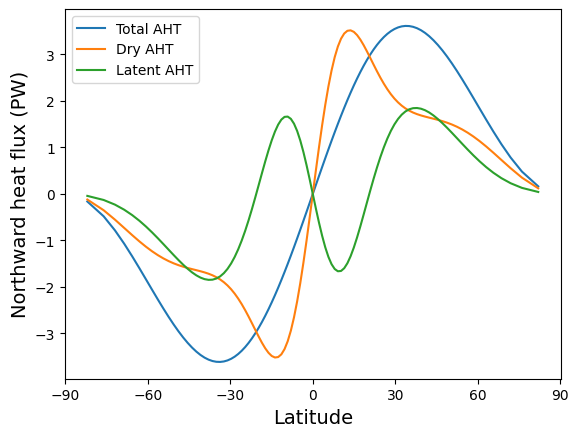

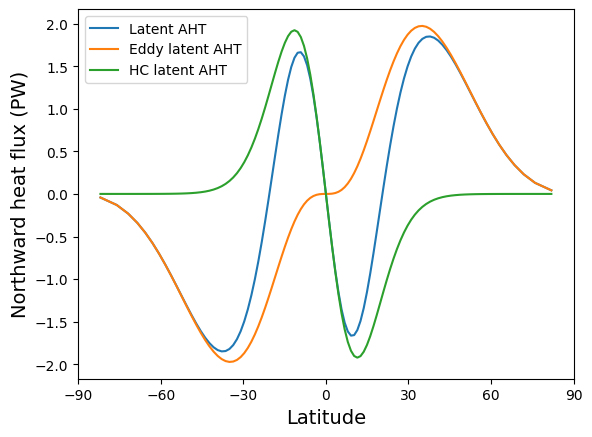

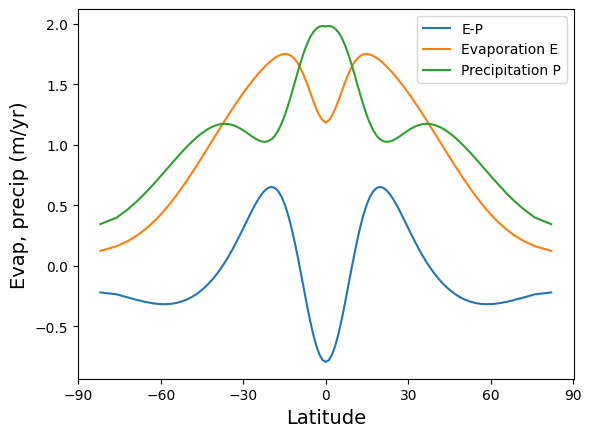

In [123]:
# Figures for climatology (ctrl)

plt.plot(phi,F_ctrl/10**15) #total heat transport
plt.plot(phi,(F_ctrl-F_LH_ctrl)/10**15) #dry
plt.plot(phi,F_LH_ctrl/10**15) #latent
plt.legend(["Total AHT", "Dry AHT", "Latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux (PW)', fontsize=14)
plt.show()

plt.plot(phi,F_LH_ctrl/10**15) #latent heat transport
plt.plot(phi,F_LH_eddy_ctrl/10**15) #eddy component of latent
plt.plot(phi,-L*V_ctrl*q_ctrl/10**15) #Hadley cell component of latent 
plt.legend(["Latent AHT", "Eddy latent AHT", "HC latent AHT"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Northward heat flux (PW)', fontsize=14)
plt.show()

plt.plot(phi,E_m_P_ctrl) #Evaporation minus precipitation (E-P) in m/yr
plt.plot(phi,E_ctrl/(L*rho)*np.pi*1e7) #Evaporation in m/yr
plt.plot(phi,P_ctrl/(L*rho)*np.pi*1e7) #Precipitation in m/yr
plt.legend(["E-P", "Evaporation E", "Precipitation P"])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Evap, precip (m/yr)', fontsize=14)
plt.show()